<a href="https://colab.research.google.com/github/bythyag/machine-learning-projects/blob/main/Wind_Power_Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [64]:
import pandas as pd
import numpy as np

In [76]:
# kaggle dataset link: https://www.kaggle.com/datasets/l3llff/wind-power
df = pd.read_csv("/content/data.csv")

In [77]:
df.head()

,dt,MW
0,2011-01-01 00:00:00,3416.0
1,2011-01-01 00:15:00,4755.0
2,2011-01-01 00:30:00,4939.0
3,2011-01-01 00:45:00,4939.0
4,2011-01-01 01:00:00,4998.0


In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 385566 entries, 0 to 385565
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   dt      385566 non-null  object 
 1   MW      385566 non-null  float64
dtypes: float64(1), object(1)
memory usage: 5.9+ MB


In [79]:
df['dt'] = pd.to_datetime(df['dt'])
df.set_index('dt', inplace=True)

In [80]:
df['MW'].isna().sum()

np.int64(0)

In [81]:
#df['MW'].isna().sum()
df['MW'] = df['MW'].interpolate(method='time')

In [82]:
df['hour'] = df.index.hour
df['day'] = df.index.day
df['weekday'] = df.index.weekday
df['month'] = df.index.month
df['quarter'] = df.index.quarter
df['year'] = df.index.year

In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 385566 entries, 2011-01-01 00:00:00 to 2021-12-30 07:45:00
Data columns (total 7 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   MW       385566 non-null  float64
 1   hour     385566 non-null  int32  
 2   day      385566 non-null  int32  
 3   weekday  385566 non-null  int32  
 4   month    385566 non-null  int32  
 5   quarter  385566 non-null  int32  
 6   year     385566 non-null  int32  
dtypes: float64(1), int32(6)
memory usage: 14.7 MB


In [84]:
# lag features
df['lag_1'] = df['MW'].shift(1)
df['lag_96'] = df['MW'].shift(96)  # same time yesterday (96 * 15min = 24hr)

# Captures trends or seasonal fluctuations
df['rolling_mean_4'] = df['MW'].rolling(window=4).mean()  # past 1 hour
df['rolling_std_96'] = df['MW'].rolling(window=96).std()  # past day

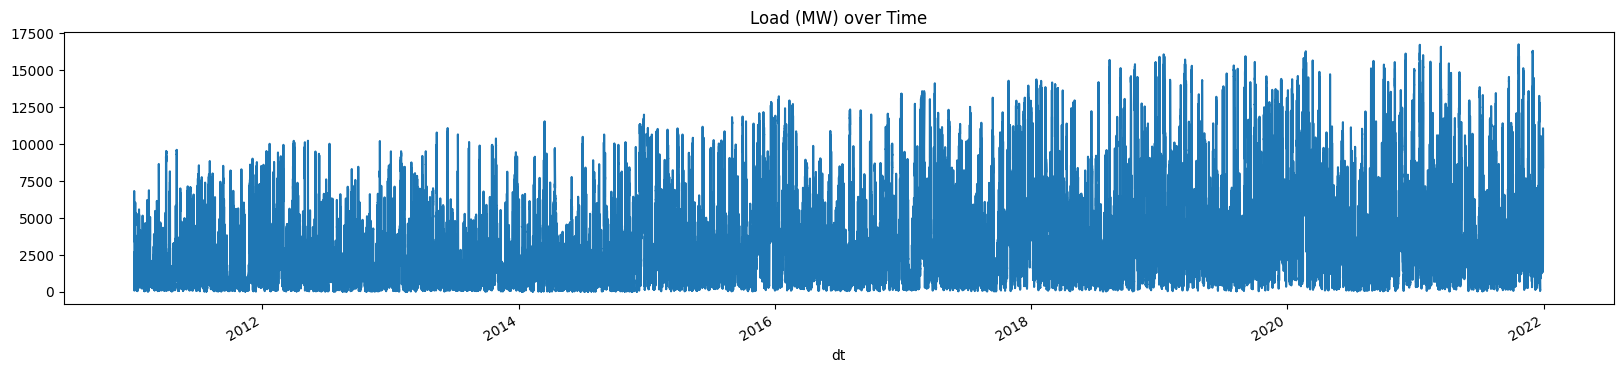

In [85]:
import matplotlib.pyplot as plt
df['MW'].plot(figsize=(20, 4))
plt.title("Load (MW) over Time")
plt.show()

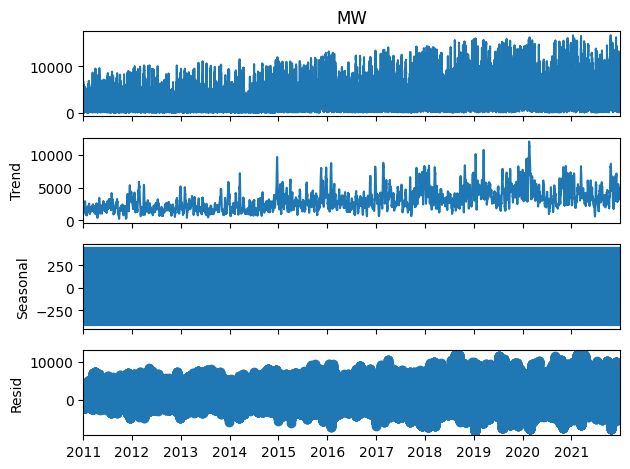

In [86]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(df['MW'], model='additive', period=672)
decomp.plot()
plt.show()

In [87]:
# Step 1: Detect outliers using IQR method
Q1 = df['MW'].quantile(0.25)
Q3 = df['MW'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Replace outliers with NaN
df['MW_cleaned'] = df['MW'].where((df['MW'] >= lower_bound) & (df['MW'] <= upper_bound), np.nan)

# Interpolate the missing values (optional smoothing)
df['MW_cleaned'] = df['MW_cleaned'].interpolate(method='time')

# Fill any edge NaNs
df['MW_cleaned'] = df['MW_cleaned'].fillna(method='bfill').fillna(method='ffill')

<ipython-input-87-ca53a26a9534>:17: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['MW_cleaned'] = df['MW_cleaned'].fillna(method='bfill').fillna(method='ffill')


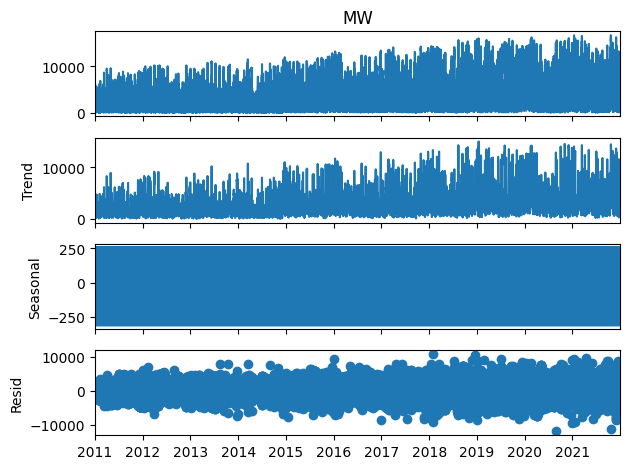

In [88]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(df['MW'], model='additive', period=96)
decomp.plot()
plt.show()

In [89]:
df_model = df.dropna()
X = df_model[['hour', 'day', 'weekday', 'month', 'lag_1', 'lag_96', 'rolling_mean_4', 'rolling_std_96']]
y = df_model['MW']

from sklearn.ensemble import RandomForestRegressor
model_rf = RandomForestRegressor()
model_rf.fit(X, y)

# Predict
y_pred = model_rf.predict(X[-96:])

In [90]:
y_pred

array([2419.5633, 2461.5701, 2561.9211, 2613.7512, 2580.0731, 2692.5967,
       2853.5238, 2850.5248, 2850.9913, 2832.6515, 2677.2153, 2632.1912,
       2676.1399, 2619.9899, 2440.3996, 2414.7745, 2369.0303, 2367.7368,
       2357.3825, 2371.1235, 2406.047 , 2426.7043, 2393.3811, 2310.1137,
       2278.2685, 2281.4278, 2357.2546, 2339.2322, 2386.9218, 2375.2365,
       2287.2182, 2199.1124, 2161.7475, 2058.2941, 1922.23  , 1802.3039,
       1702.7215, 1604.0566, 1438.7031, 1333.1511, 1334.64  , 1348.1413,
       1392.4756, 1375.2838, 1387.7646, 1484.1329, 1593.8943, 1692.4259,
       1748.7226, 1761.3372, 1808.9335, 1918.2306, 2026.6622, 2137.1609,
       2221.262 , 2292.6007, 2363.7417, 2494.3788, 2624.5291, 2853.5557,
       3043.8971, 3272.5997, 3382.9775, 3513.195 , 9926.1859, 4397.6724,
       5372.1453, 5650.987 , 4898.216 , 5111.6325, 5201.3021, 5420.7494,
       5521.114 , 5713.9906, 6034.5917, 6333.4062, 6369.1389, 6103.7576,
       6329.0005, 6425.709 , 6414.3375, 6547.7077, 

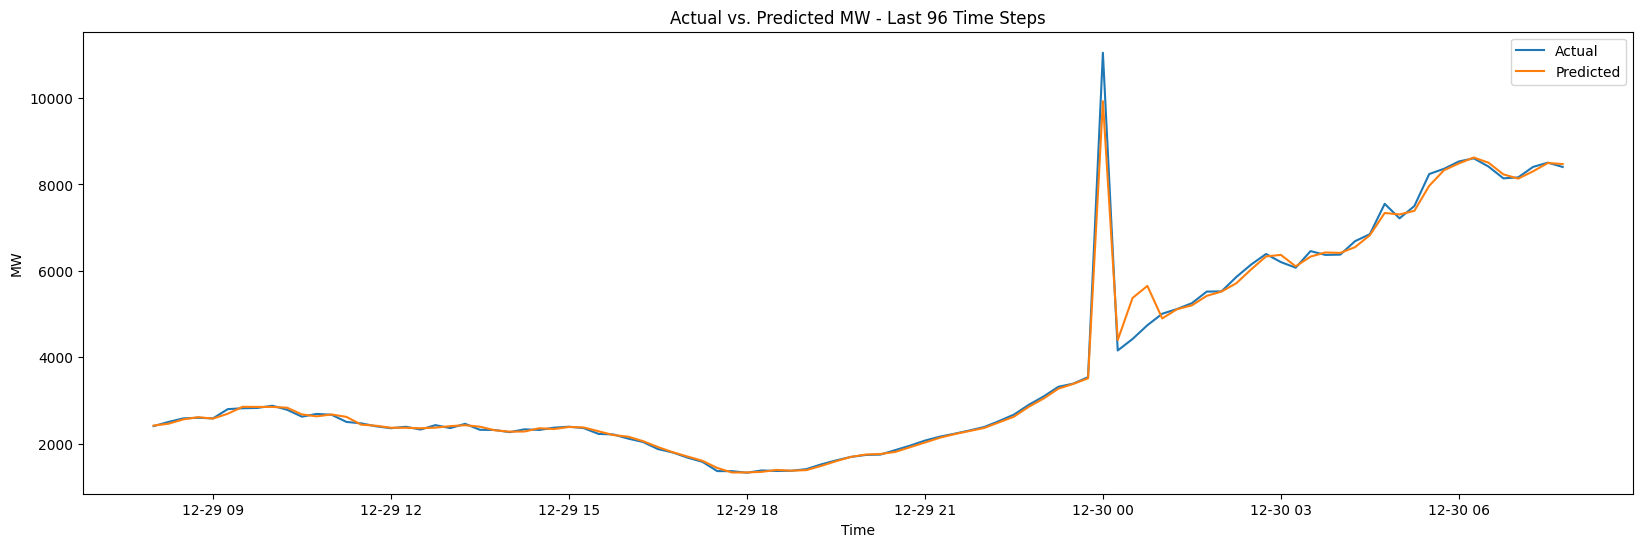

In [91]:
# Plot the historical data and the predictions
plt.figure(figsize=(20, 6))
plt.plot(df_model.index[-96:], y[-96:], label='Actual')
plt.plot(df_model.index[-96:], y_pred, label='Predicted')
plt.title('Actual vs. Predicted MW - Last 96 Time Steps')
plt.xlabel('Time')
plt.ylabel('MW')
plt.legend()
plt.show()

<ipython-input-94-c90c64548e49>:3: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  future_index = pd.date_range(start=df.index[-1] + pd.Timedelta(minutes=15), periods=future_steps, freq='15T')


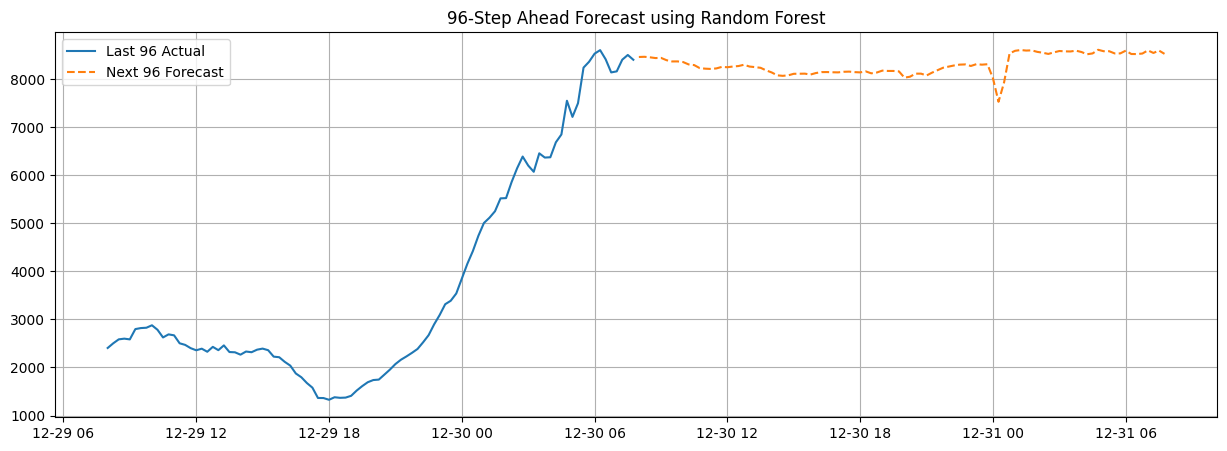

In [94]:
# Forecast 96 future steps
future_steps = 96
future_index = pd.date_range(start=df.index[-1] + pd.Timedelta(minutes=15), periods=future_steps, freq='15T')
future_df = pd.DataFrame(index=future_index)

# Pre-fill calendar features
future_df['hour'] = future_df.index.hour
future_df['day'] = future_df.index.day
future_df['weekday'] = future_df.index.weekday
future_df['month'] = future_df.index.month

# Initialize with last known values
last_known = df.copy()
for i in range(future_steps):
    row_time = future_df.index[i]

    lag_1 = last_known['MW_cleaned'].iloc[-1]
    lag_96 = last_known['MW_cleaned'].iloc[-96] if len(last_known) >= 96 else lag_1
    rolling_mean_4 = last_known['MW_cleaned'].iloc[-4:].mean()
    rolling_std_96 = last_known['MW_cleaned'].iloc[-96:].std()

    # Build feature row
    row = pd.DataFrame({
        'hour': [row_time.hour],
        'day': [row_time.day],
        'weekday': [row_time.weekday()],
        'month': [row_time.month],
        'lag_1': [lag_1],
        'lag_96': [lag_96],
        'rolling_mean_4': [rolling_mean_4],
        'rolling_std_96': [rolling_std_96]
    }, index=[row_time])

    # Predict
    prediction = model_rf.predict(row)[0]
    row['MW_cleaned'] = prediction

    # Append to last_known for next iteration
    last_known = pd.concat([last_known, row])

# Extract predictions
forecast = last_known[-future_steps:]['MW_cleaned']

# Step 4: Plot
plt.figure(figsize=(15, 5))
plt.plot(df['MW_cleaned'][-96:], label='Last 96 Actual')
plt.plot(forecast, label='Next 96 Forecast', linestyle='--')
plt.title("96-Step Ahead Forecast using Random Forest")
plt.legend()
plt.grid()
plt.show()


In [95]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Predict on train set
y_pred_train = model_rf.predict(X)

mae = mean_absolute_error(y, y_pred_train)
rmse = np.sqrt(mean_squared_error(y, y_pred_train))
r2 = r2_score(y, y_pred_train)

print(f"Train MAE: {mae:.2f}")
print(f"Train RMSE: {rmse:.2f}")
print(f"Train R² Score: {r2:.4f}")

Train MAE: 38.56
Train RMSE: 100.56
Train R² Score: 0.9989


In [97]:
# Use last 20% of data as test set
split_idx = int(0.8 * len(df))
train = df.iloc[:split_idx]
test = df.iloc[split_idx:]

X_train = train[['hour', 'day', 'weekday', 'month', 'lag_1', 'lag_96', 'rolling_mean_4', 'rolling_std_96']]
y_train = train['MW_cleaned']
X_test = test[['hour', 'day', 'weekday', 'month', 'lag_1', 'lag_96', 'rolling_mean_4', 'rolling_std_96']]
y_test = test['MW_cleaned']

model_rf.fit(X_train, y_train)
y_pred_test = model_rf.predict(X_test)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
print("Test MAE:", mean_absolute_error(y_test, y_pred_test))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_test)))
print("Test R²:", r2_score(y_test, y_pred_test))


Test MAE: 272.51595088111
Test RMSE: 790.3964758348915
Test R²: 0.9202023468036126


In [98]:
# Use last 20% of data as test set but with smaller features and more parameter tuned random forest
split_idx = int(0.8 * len(df))
train = df.iloc[:split_idx]
test = df.iloc[split_idx:]

model_rf = RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_leaf=20)

X_train = train[['hour', 'weekday', 'lag_1', 'rolling_mean_4']]
y_train = train['MW_cleaned']
X_test = test[['hour', 'weekday', 'lag_1', 'rolling_mean_4']]
y_test = test['MW_cleaned']

model_rf.fit(X_train, y_train)
y_pred_test = model_rf.predict(X_test)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
print("Test MAE:", mean_absolute_error(y_test, y_pred_test))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_test)))
print("Test R²:", r2_score(y_test, y_pred_test))


Test MAE: 281.50499085467897
Test RMSE: 754.0738074449099
Test R²: 0.9273680271562182


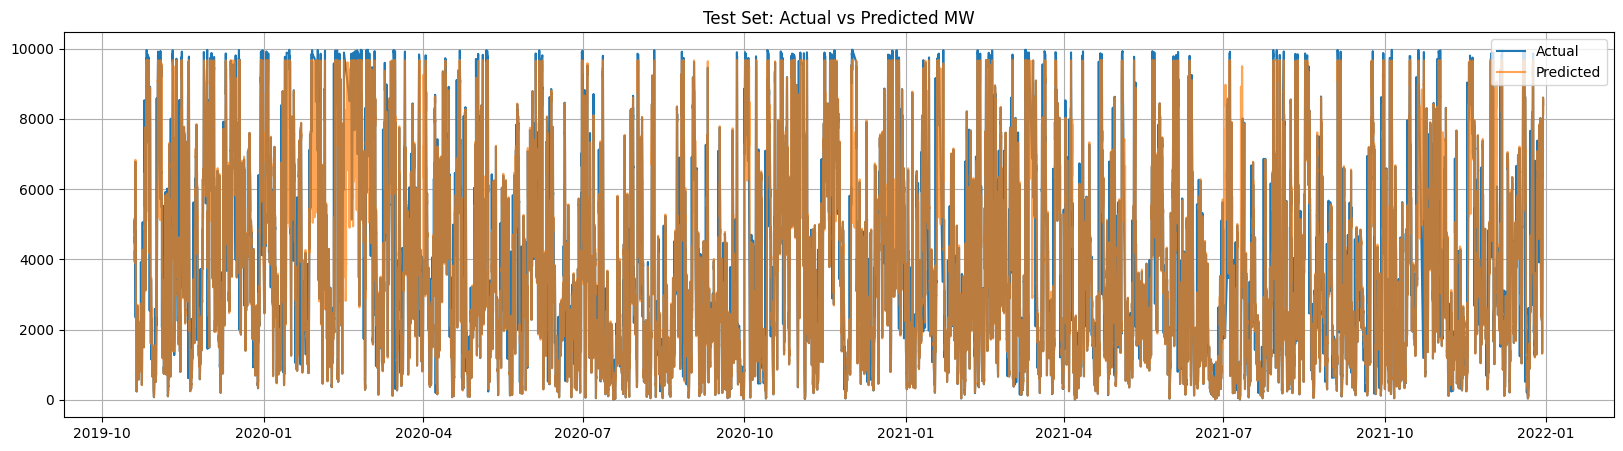

In [100]:
plt.figure(figsize=(20,5))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred_test, label='Predicted', alpha=0.7)
plt.title("Test Set: Actual vs Predicted MW")
plt.legend()
plt.grid()
plt.show()


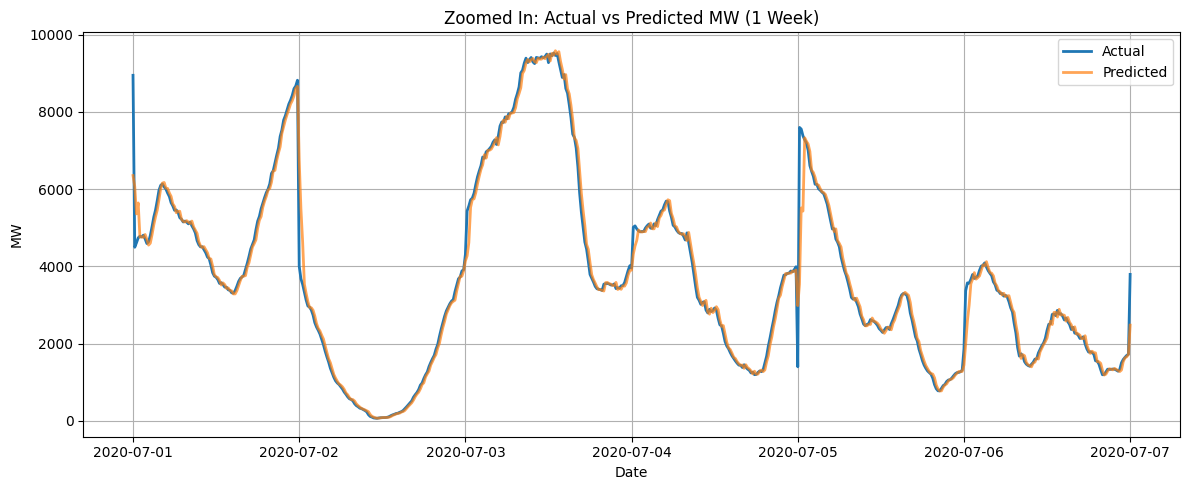

In [107]:
# Select a small time interval from the test set — adjust the range as needed
start_date = '2020-07-01'
end_date = '2020-07-07'

# Filter data for that interval
mask = (y_test.index >= start_date) & (y_test.index <= end_date)
y_test_zoom = y_test.loc[mask]
y_pred_zoom = y_pred_test[mask]

# Plot
import matplotlib.pyplot as plt

# Plot using the index from y_test_zoom for both lines
plt.figure(figsize=(12,5))
plt.plot(y_test_zoom.index, y_test_zoom, label='Actual', linewidth=2)
plt.plot(y_test_zoom.index, y_pred_zoom, label='Predicted', linewidth=2, alpha=0.7)
plt.title("Zoomed In: Actual vs Predicted MW (1 Week)")
plt.xlabel("Date")
plt.ylabel("MW")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

